In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


# 不显示警告
import warnings
warnings.filterwarnings("ignore")

In [2]:
class MyDataset(Dataset):
    '''加载数据集的类'''

    def __init__(self, root_dir, cls):
        '''初始化数据集,主要步骤如下:
        1.加载所有的csv表格'''

        self.df_l = []
        self.samples_all = 0  # 记录产生的sample time series总量
        self.samples_l = []  # 记录各个csv数据产生的sample time series长度
        self.window_len = int(WINDOW_LEN * 100)
        self.trouble_len = int(TROUBLE_LEN * 100)
        self.window_span = int(WINDOW_SPAN * 100)

        for file in TQDM(os.listdir(root_dir), desc='加载%s数据' % cls):
            if not file.endswith('.csv'):  # 非csv数据跳过
                continue

            df_this = pd.read_csv(os.path.join(
                root_dir, file), usecols=FEAT_SELECT).fillna(method='ffill')

            LEN = len(df_this)
            # 最后TROUBLE_LEN长度添加上标签1(其余是0),定义为列label
            label = np.concatenate([np.zeros(LEN - self.trouble_len),
                                    np.ones(self.trouble_len)])
            df_this['label'] = label.astype(int)
            self.df_l.append(df_this)

            # 计算本csv数据能够产生的窗口数量
            window_num = (LEN - self.window_len + 1) // self.window_span
            self.samples_l.append(window_num)
            self.samples_all += window_num

    def __len__(self):
        return self.samples_all

    def construct_dataset(self):
        '''构建特征集的函数'''
        # pd.concat([a1,a2],axis=1)
        feat_l, label_l = [], []  # 存储所有中间ser的的list
        for i in TQDM(range(self.samples_all), desc='数据集特征构建中'):
            feat, label = self[i]
            feat_l.append(feat)
            label_l.append(label)

        X = pd.concat(feat_l, axis=1).T
        y = np.array(label_l)
        return X, y

    def __getitem__(self, idx):
        # 找出两个索引位置
        samples_cumsum = np.array(self.samples_l).cumsum()
        key1 = np.searchsorted(samples_cumsum, idx + 1)
        # 大于第一个cumsum 要减去前面的累加值，否则就是idx
        key2 = idx - samples_cumsum[key1 - 1] if key1 > 0 else idx
        key2 = key2 * self.window_span

        # 通过key1找到对应的df
        target_df = self.df_l[key1]

        # 通过key2找到对应的value
        df_sample = target_df.iloc[key2: key2 + self.window_len]

        X = df_sample.drop('label', axis=1)
        y = df_sample['label'].iloc[-1]

        feat_ser = pd.Series()
        # 对于每一个time series，计算下列特征
        for fname in X.columns:

            xc = X[fname]  # 时域序列
            zc = np.fft.fft(xc)  # 频域序列
            realFFT, imagFFT = np.real(zc), np.imag(zc)

            # --------------------时域特征 --------------------
            # 分位数
            feat_ser[fname + '01p'] = xc.quantile(0.01)
            feat_ser[fname + '05p'] = xc.quantile(0.05)
            feat_ser[fname + '95p'] = xc.quantile(0.95)
            feat_ser[fname + '99p'] = xc.quantile(0.99)
            # 跨度
            feat_ser[fname + '_ptp'] = xc.ptp()
            feat_ser[fname + '_ptp_abs'] = xc.abs().ptp()

            # 全体/首尾n_percent   mean/std/min/max/mean_change/mean_change_rate
            feat_ser[fname + '_mean'] = xc.mean()
            feat_ser[fname + '_std'] = xc.std()
            feat_ser[fname + '_max'] = xc.max()
            feat_ser[fname + '_min'] = xc.min()
            feat_ser[fname + '_mean_change_abs'] = xc.diff().abs().mean()
            feat_ser[fname + '_mean_change_rate'] = (
                (xc + 1e-7).diff().abs() / (xc + 1e-7).abs()).mean()

            n_percent = int(len(xc) * 0.05)
            first_percent10 = xc[-n_percent:]
            feat_ser[fname + '_mean_first_percent'] = first_percent10.mean()
            feat_ser[fname + '_std_first_percent'] = first_percent10.std()
            feat_ser[fname + '_max_first_percent'] = first_percent10.max()
            feat_ser[fname + '_min_first_percent'] = first_percent10.min()
            feat_ser[fname + '_mean_change_first_percent'] = first_percent10.diff().mean()
            feat_ser[fname + '_mean_change_rate_first_percent'] = (
                (first_percent10 + 1e-7).diff().abs() / (first_percent10 + 1e-7).abs()).mean()

            last_percent = xc[-n_percent:]
            feat_ser[fname + '_mean_last_percent'] = last_percent.mean()
            feat_ser[fname + '_std_last_percent'] = last_percent.std()
            feat_ser[fname + '_max_last_percent'] = last_percent.max()
            feat_ser[fname + '_min_last_percent'] = last_percent.min()
            feat_ser[fname + '_mean_change_first_percent'] = last_percent.diff().abs().mean()
            feat_ser[fname + '_mean_change_rate_first_percent'] = (
                (last_percent + 1e-7).diff().abs() / (last_percent + 1e-7).abs()).mean()

#             # rolling特征
#             for windows in [100, 500]:
#                 # 滑窗特征
#                 x_roll_std = xc.rolling(windows).std().dropna()
#                 x_roll_mean = xc.rolling(windows).mean().dropna()

#                 feat_ser[fname + '_mean_roll_std_' +str(windows)] = x_roll_std.mean()
#                 feat_ser[fname + '_std_roll_std_' +str(windows)] = x_roll_std.std()
#                 feat_ser[fname + '_max_roll_std_' +str(windows)] = x_roll_std.max()
#                 feat_ser[fname + '_min_roll_std_' +str(windows)] = x_roll_std.min()
#                 feat_ser[fname + '_q01_roll_std_' +str(windows)] = x_roll_std.quantile(0.01)
#                 feat_ser[fname + '_q05_roll_std_' +str(windows)] = x_roll_std.quantile(0.05)
#                 feat_ser[fname + '_q95_roll_std_' +str(windows)] = x_roll_std.quantile(0.95)
#                 feat_ser[fname + '_q99_roll_std_' +str(windows)] = x_roll_std.quantile(0.99)
#                 feat_ser[fname + 'mean_change_abs_roll_std_' +str(windows)] = x_roll_std.diff().abs().mean()
#                 feat_ser[fname + 'mean_change_rate_roll_std_' + str(windows)] = (
#                     (x_roll_std + 1e-7).diff().abs() / (x_roll_std + 1e-7).abs()).mean()

#                 feat_ser[fname + '_mean_roll_mean_' +str(windows)] = x_roll_mean.mean()
#                 feat_ser[fname + '_std_roll_mean_' +str(windows)] = x_roll_mean.std()
#                 feat_ser[fname + '_max_roll_mean_' +str(windows)] = x_roll_mean.max()
#                 feat_ser[fname + '_min_roll_mean_' +str(windows)] = x_roll_mean.min()
#                 feat_ser[fname + '_q01_roll_mean_' +str(windows)] = x_roll_mean.quantile(0.01)
#                 feat_ser[fname + '_q05_roll_mean_' +str(windows)] = x_roll_mean.quantile(0.05)
#                 feat_ser[fname + '_q95_roll_mean_' +str(windows)] = x_roll_mean.quantile(0.95)
#                 feat_ser[fname + '_q99_roll_mean_' +str(windows)] = x_roll_mean.quantile(0.99)
#                 feat_ser[fname + 'mean_change_abs_roll_mean_' +str(windows)] = x_roll_mean.diff().abs().mean()
#                 feat_ser[fname + 'mean_change_rate_roll_mean_' + str(windows)] = (
#                     (x_roll_mean + 1e-7).diff().abs() / (x_roll_mean + 1e-7).abs()).mean()


            # --------------------频域特征 --------------------
            feat_ser[fname + '_Rmean'] = realFFT.mean()
            feat_ser[fname + '_Rstd'] = realFFT.std()
            feat_ser[fname + '_Rmax'] = realFFT.max()
            feat_ser[fname + '_Rmin'] = realFFT.min()

            feat_ser[fname + '_Imean'] = imagFFT.mean()
            feat_ser[fname + '_Istd'] = imagFFT.std()
            feat_ser[fname + '_Imax'] = imagFFT.max()
            feat_ser[fname + '_Imin'] = imagFFT.min()


        return (feat_ser, y)  # shapeX= (3000,feat_num) shapey=(3000)

    
    
    
# -------------------------- 模型训练主函数 ------------------------------
def train_eval_model(model):
    '''训练测试主函数'''

    print('模型 %s 评测中....' % model.__class__.__name__)
    # 归一化特征
    X_train_scale = SCALE.fit_transform(X_train)
    X_test_scale = SCALE.fit_transform(X_test)

    # 模型拟合和预测
    model.fit(X_train_scale, y_train)
    y_test_pred = model.predict(X_test_scale)

    # 评价指标
    test_acc = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    return (test_acc, test_auc, test_f1)



In [3]:

# -------------------------- 可调参数 ------------------------------
# TQDM显示选项
TQDM = tqdm_notebook
# TQDM = tqdm
# 训练/测试 数据存储路径
TRAIN_DIR, TEST_DIR = './train', './test'
# 故障标签长度(s)
TROUBLE_LEN = 0.5
# WINDOW时间长度(s)
WINDOW_LEN = 59
# 窗口滑动长度(s)
WINDOW_SPAN = 0.02
# 选择使用的特征列表
FEAT_SELECT = ['[8:2]', '[6:17]', '[1:7]', '[1:5]',
               '[1:20]', '[1:0]', '[1:1]', '[8:4]', '[1:133]']
# 归一化选项
SCALE = StandardScaler()


# 数据集构建

In [4]:
print('=================== 数据集构建 ===================')
train_dataset = MyDataset(root_dir=TRAIN_DIR, cls='训练')
test_dataset = MyDataset(root_dir=TEST_DIR, cls='测试')

print('=================== 训练集特征构建 ===================')
X_train, y_train = train_dataset.construct_dataset()
print('=================== 测试集特征构建 ===================')
X_test, y_test = test_dataset.construct_dataset()

=================== 数据集构建 ===================



=================== 训练集特征构建 ===================



=================== 测试集特征构建 ===================


# 训练

In [9]:
X_train.to_csv('tmp.csv')

In [106]:
# 模型初始化
clf_rf = RandomForestClassifier(n_estimators=200)
clf_svm = SVC(max_iter=1000,C=0.15)
clf_nn = MLPClassifier(hidden_layer_sizes=500)


# 评测模型
rf_scores = train_eval_model(clf_rf)
svm_scores = train_eval_model(clf_svm)
nn_scores = train_eval_model(clf_nn)

df_res = pd.DataFrame({'RF': rf_scores, 'SVM': svm_scores, 'NN': nn_scores},
                                              index=['ACC', 'AUC', 'F1'])

df_res

模型 RandomForestClassifier 评测中....
模型 SVC 评测中....
模型 MLPClassifier 评测中....


,RF,SVM,NN
ACC,0.880000,0.600000,0.640000
AUC,0.878205,0.583333,0.641026
F1,0.869565,0.285714,0.640000


# 可视化

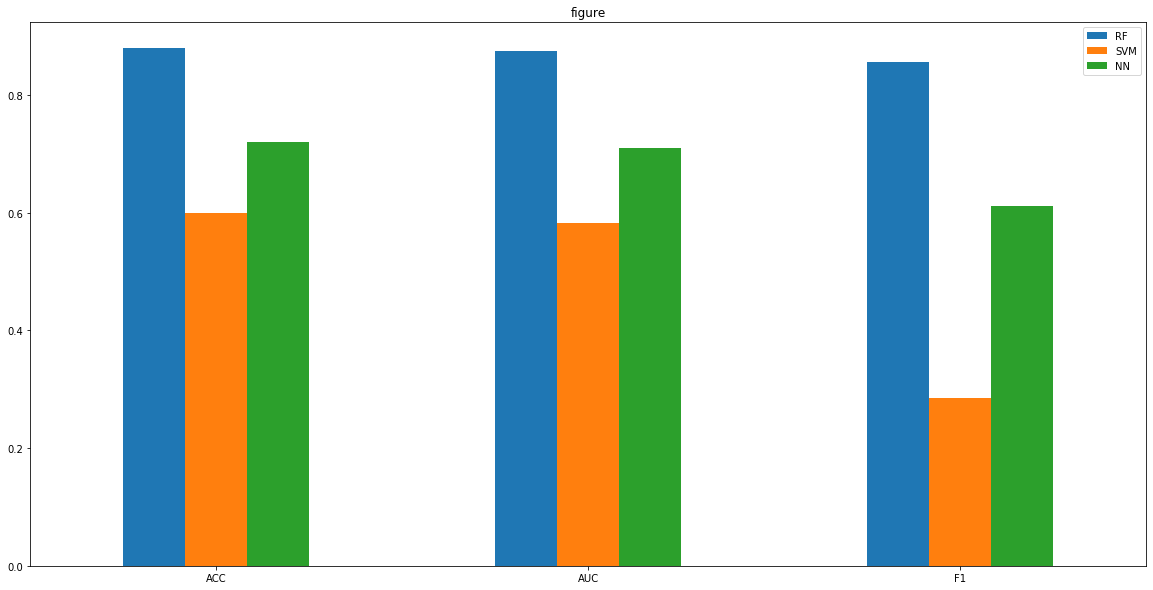

In [104]:
df_res.plot(kind='bar',figsize=(20,10),title='figure',rot=0)

In [121]:
# 特征的重要程度可视化
df_feature_importances=pd.DataFrame()
df_feature_importances['Features']=X_train.columns
df_feature_importances['Importance']=clf_rf.feature_importances_
df_feature_importances=df_feature_importances.sort_values(by='Importance',ascending=False)
df_feature_importances

,Features,Importance
3,[1:0]99p,0.025
363,[1:133]_std_first_percent,0.015
345,[1:20]_Rmin,0.015
471,[6:17]mean_change_rate_roll_std_500,0.015
312,[1:20]_mean_roll_mean_100,0.015
176,[1:5]_q01_roll_mean_100,0.015
541,[8:2]mean_change_rate_roll_std_500,0.015
134,[1:1]_Rmax,0.015
333,[1:20]_std_roll_mean_500,0.015
89,[1:1]_std_last_percent,0.015


Text(0.5, 1.0, 'Features Importance Figure')

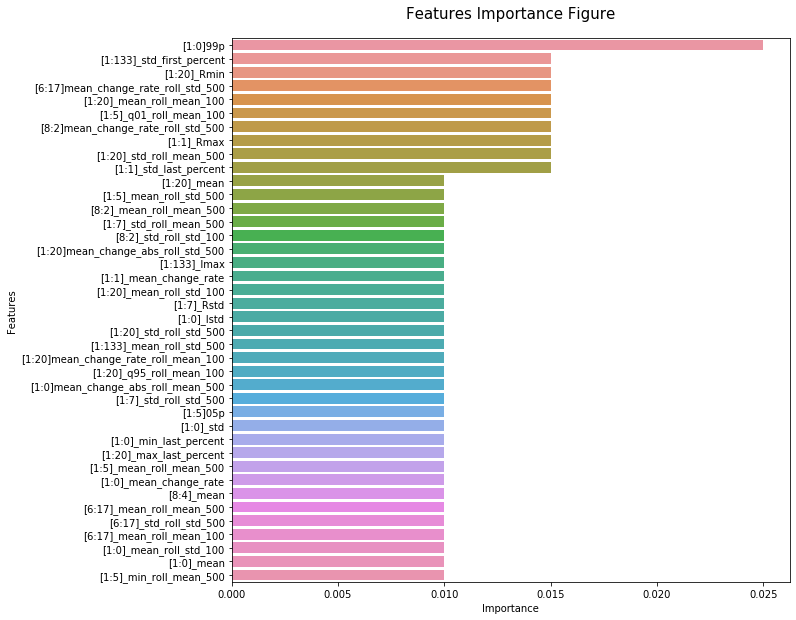

In [151]:
# df_feature_importances[:20].set_index('Features').plot(kind='barh',figsize=(10,10))

import seaborn as sns

plt.figure(figsize=(10,10))
sns.barplot(x="Importance", y="Features", data=df_feature_importances[:40])
plt.title('Features Importance Figure',fontsize=15,pad=20)